In [1]:
import numpy
import torchvision

train = torchvision.datasets.FashionMNIST('fmnist', train = True, download = False)
test = torchvision.datasets.FashionMNIST('fmnist', train = False, download = False)

train_images = numpy.array([ numpy.array(item[0]) / 255 for item in train ])
train_labels = numpy.array([ item[1] for item in train ])

test_images = numpy.array([ numpy.array(item[0]) / 255 for item in test ])
test_labels = numpy.array([ item[1] for item in test ])

In [2]:
import cvtda.topology
extractor = cvtda.topology.FeatureExtractor(only_get_from_dump = False, return_diagrams = False)
extractor = extractor.fit(train_images, "2/train")
train_features = extractor.transform(train_images, "2/train")
test_features = extractor.transform(test_images, "2/test")

Calculating inverted images
GreyscaleExtractor: processing 2/train/greyscale, do_fit = True
Got the result from ./2/train/greyscale/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ./2/train/greyscale/features.npy
GreyscaleExtractor: processing 2/train/greyscale, do_fit = False
Got the result from ./2/train/greyscale/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ./2/train/greyscale/features.npy
GreyscaleExtractor: processing 2/train/inverted_greyscale, do_fit = True
Got the result from ./2/train/inverted_greyscale/diagrams.npy
Applying Scaler to persistence diagrams.
DiagramVectorizer: fitting complete
Got the result from ./2/train/inverted_greyscale/features.npy
GreyscaleExtractor: processing 2/train/inverted_greyscale, do_fit = False
Got the result from ./2/train/inverted_greyscale/diagrams.npy
Applying Scaler to persistence diagrams.
Got the result from ./2/train/inverted_greyscale/features.npy


In [3]:
import cvtda.classification
IV = cvtda.classification.calculate_information_value(train_features, train_labels)

import pandas
scores = pandas.DataFrame([ IV, extractor.feature_names() ]).transpose()
scores.columns = [ "IV", "feature" ]

import os
os.makedirs(os.path.dirname("3/scores.csv"), exist_ok = True)
scores.to_csv("3/scores.csv")
scores

information values:   0%|          | 1/10278 [00:07<22:31:20,  7.89s/it]d:\Programs\Programming\Python\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
information values: 100%|██████████| 10278/10278 [01:02<00:00, 163.38it/s]


,IV,feature
0,0.428864,greyscale -> betti-0
1,0.426891,greyscale -> betti-1
2,0.484448,greyscale -> betti-2
3,0.642954,greyscale -> betti-3
4,0.476893,greyscale -> betti-4
...,...,...
10273,0.565217,geometry -> curvature-19
10274,0.436073,geometry -> curvature-20
10275,1.626137,geometry -> curvature-21
10276,1.64193,geometry -> curvature-22


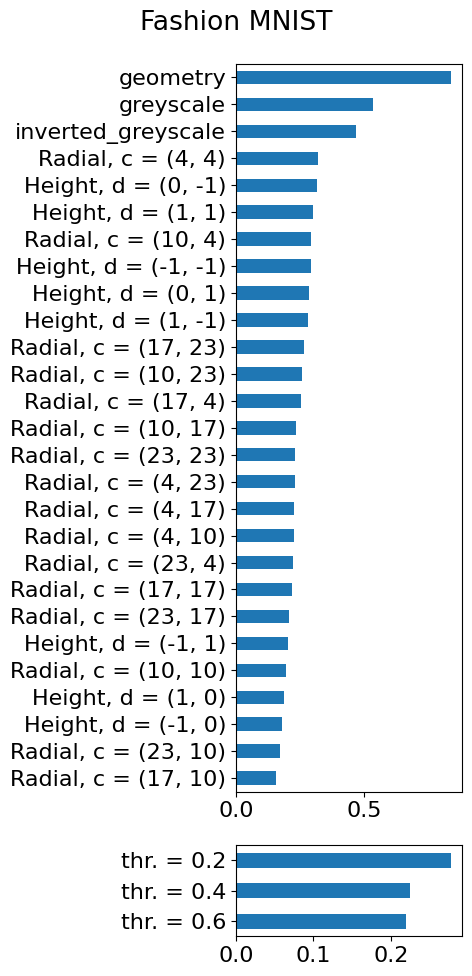

In [1]:
import re
import pandas
import matplotlib.pyplot as plt

def parse_filtration(value):
    if value in ('greyscale', 'inverted_greyscale', 'geometry'): return value
    return ', '.join(re.match(r"(.*)Filtration with (.*)", value).groups())
scores = pandas.read_csv("3/scores.csv")
scores['IV'] = scores['IV'].astype(float)
scores[["type", "details"]] = scores["feature"].str.split(" -> ", expand = True)
scores[["name", "threshold"]] = scores["type"].str.split(", bin. ", expand = True)
scores["name"] = scores["name"].apply(parse_filtration)

def draw(by: str, ax):
    grouped = scores.groupby(by = by).mean(numeric_only = True).reset_index()
    grouped = grouped.sort_values(by = 'IV', ascending = True)
    grouped.plot.barh(x = by, y = 'IV', ax = ax, legend = None)
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.rcParams.update({'font.size': 16})
fig, (ax_name, ax_threshold) = plt.subplots(2, 1, figsize = (5, 10), height_ratios = [ 8, 1 ])
fig.suptitle("Fashion MNIST")
draw('name', ax_name)
draw('threshold', ax_threshold)
fig.tight_layout()
fig.savefig("3/iv.png")
fig.savefig("3/iv.svg")